<a href="https://colab.research.google.com/github/linh0941664362/anomaly-stock-maket-by-deep-learning-GRU-ARIMA-DRNN-FINENET-/blob/main/Gr8_Ho%C3%A0n_ch%E1%BB%89nh_voting_added.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  Cài thư viện cần thiết
!pip install pandas numpy matplotlib scikit-learn statsmodels tensorflow ta --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
#  Nhập thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, concatenate, GRU, LSTM, BatchNormalization, Bidirectional
import random
import os

def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds()

warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Châu29-3.xlsx to Châu29-3.xlsx


In [ ]:
#  Load dữ liệu
df = pd.read_excel('Châu29-3.xlsx')
df = df.rename(columns={'time': 'Date', 'close': 'Price'})
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.sort_index()
print(df.head())

            week   open   high    low  Price   volume  weekly ROI  \
Date                                                                
2017-07-10     1  10.56  10.56   9.94  10.30  2677240   -4.466019   
2017-07-11     1  10.32  10.32   9.94  10.11   838360   -4.466019   
2017-07-12     1  10.11  10.27  10.04  10.15   376520   -4.466019   
2017-07-13     1  10.13  10.13   9.99   9.99   780690   -4.466019   
2017-07-14     1   9.96  10.04   9.82   9.84   605590   -4.466019   

            weekly Mean  weekly Standard deviation  mean all ROI  STD all ROI  \
Date                                                                            
2017-07-10       10.078                   0.173118      0.621472     5.845873   
2017-07-11       10.078                   0.173118      0.621472     5.845873   
2017-07-12       10.078                   0.173118      0.621472     5.845873   
2017-07-13       10.078                   0.173118           NaN          NaN   
2017-07-14       10.078       

In [ ]:
print(df.columns.tolist())


['week', 'open', 'high', 'low', 'Price', 'volume', 'weekly ROI', 'weekly Mean', 'weekly Standard deviation', 'mean all ROI', 'STD all ROI', 'k', 'lower limit', 'upper limit ', 'highlight ROI for k=0.5', 'highlight ROI for k=1', 'highlight ROI for k=1.5']


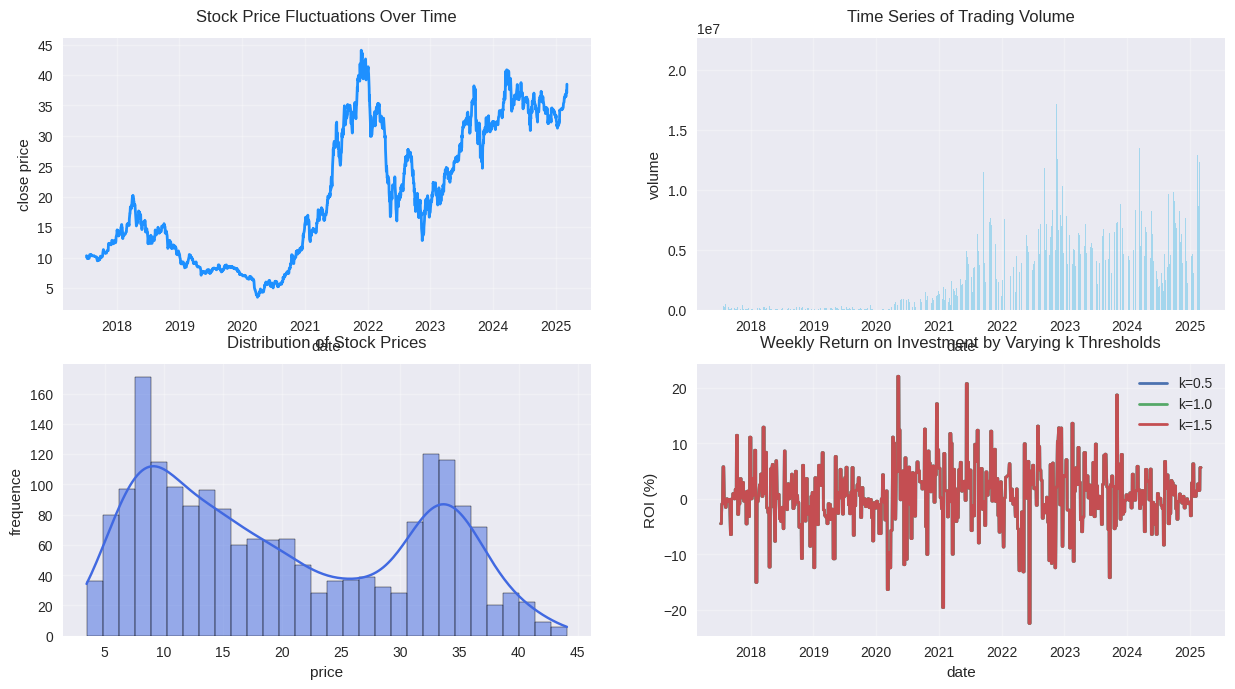

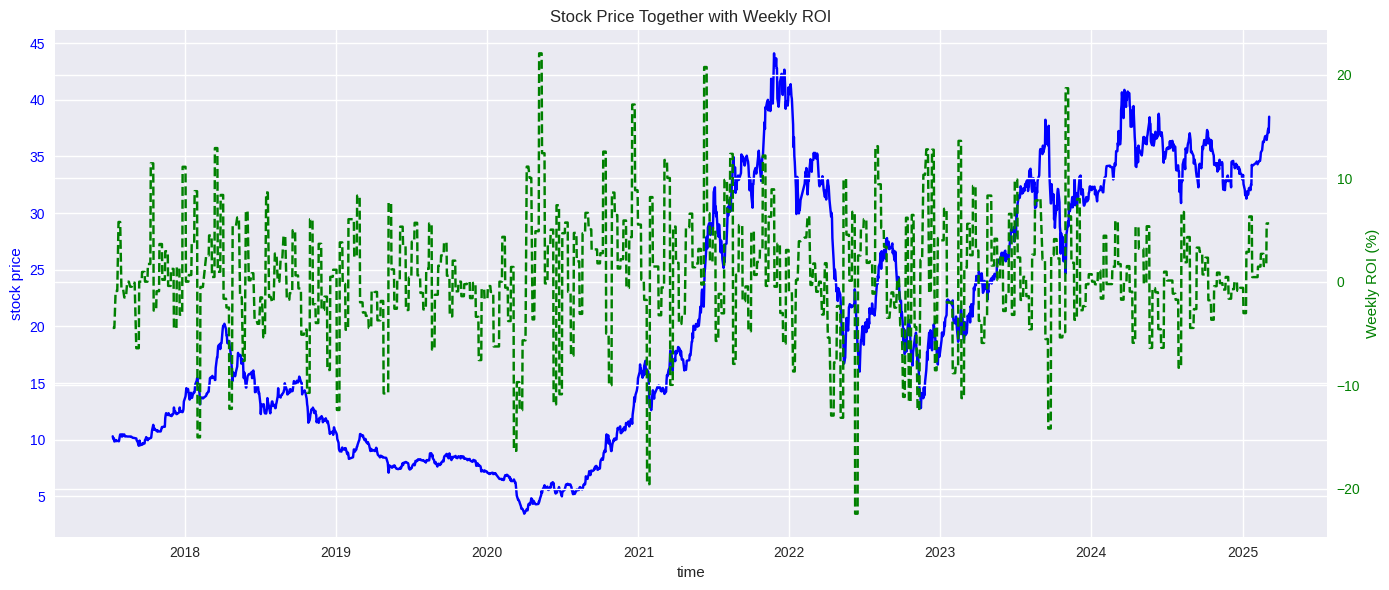

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Thiết lập style
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(15, 12))

# 1. Biểu đồ diễn biến giá theo thời gian
plt.subplot(3, 2, 1)
plt.plot(df.index, df['Price'], color='dodgerblue', linewidth=2)
plt.title('Stock Price Fluctuations Over Time', pad=12)
plt.xlabel('date')
plt.ylabel('close price')
plt.grid(True, alpha=0.3)

# 2. Biểu đồ volume giao dịch
plt.subplot(3, 2, 2)
plt.bar(df.index, df['volume'], color='skyblue', alpha=0.7)
plt.title('Time Series of Trading Volume', pad=12)
plt.xlabel('date')
plt.ylabel('volume')
plt.grid(True, alpha=0.3)

# 3. Biểu đồ phân bố giá
plt.subplot(3, 2, 3)
sns.histplot(df['Price'], kde=True, color='royalblue', bins=30)
plt.title('Distribution of Stock Prices', pad=12)
plt.xlabel('price')
plt.ylabel('frequence')
plt.grid(True, alpha=0.3)

# 4. Biểu đồ ROI theo các ngưỡng k
plt.subplot(3, 2, 4)
for k in [0.5, 1.0, 1.5]:
    # Thay đổi cách tạo tên cột để khớp với DataFrame
    col = f'highlight ROI for k={k if k != 1.0 else 1}'
    sns.lineplot(x=df.index, y=df[col], label=f'k={k}', linewidth=2)
plt.title('Weekly Return on Investment by Varying k Thresholds', pad=12)
plt.xlabel('date')
plt.ylabel('ROI (%)')
plt.legend()
plt.grid(True, alpha=0.3)
# 5
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_xlabel('time')
ax1.set_ylabel('stock price', color='blue')
ax1.plot(df['Price'], color='blue', label='Price')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Weekly ROI (%)', color='green')
ax2.plot(df['weekly ROI'], color='green', linestyle='--', label='Weekly ROI')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Stock Price Together with Weekly ROI')
fig.tight_layout()
plt.grid(True)

plt.show()


In [ ]:
#  Chọn cột liên quan
selected_cols = ['Price', 'weekly ROI', 'highlight ROI for k=0.5', 'highlight ROI for k=1', 'highlight ROI for k=1.5']
df = df[selected_cols]

# Thay vì dropna toàn bộ, chỉ drop nếu tất cả giá trị đều NaN
# hoặc fill tạm bằng 0 để giữ lại nhiều dữ liệu hơn
if df.isnull().sum().sum() > 0:
    df = df.fillna(method='ffill').fillna(method='bfill')

In [ ]:
#  Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
df[['Price', 'weekly ROI']] = scaler.fit_transform(df[['Price', 'weekly ROI']])


In [ ]:
#  Tạo dữ liệu theo window
def create_dataset(data, target_reg, target_cls, window_size=10):
    X, y_reg, y_cls = [], [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y_reg.append(target_reg[i])
        y_cls.append(target_cls[i])
    return np.array(X), np.array(y_reg), np.array(y_cls)

k_columns = {
    0.5: 'highlight ROI for k=0.5',
    1.0: 'highlight ROI for k=1',
    1.5: 'highlight ROI for k=1.5'
}

results = []
for k, label_col in k_columns.items():
    print(f"\n========== Evaluating with k = {k} ==========")

    data = df[['Price']].values
    target_reg = df['weekly ROI'].values
    target_cls = df[label_col].values

    X, y_reg, y_cls = create_dataset(data, target_reg, target_cls, window_size=10)
    if len(X) == 0:
        print("⚠️ Không đủ dữ liệu cho k =", k)
        continue

    from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Price_scaled'] = scaler.fit_transform(df[['Price']])

split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train_reg, y_test_reg = y_reg[:split], y_reg[split:]
y_train_cls, y_test_cls = y_cls[:split], y_cls[split:]


========== Evaluating with k = 0.5 ==========

========== Evaluating with k = 1.0 ==========

========== Evaluating with k = 1.5 ==========


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv1D, BatchNormalization, GRU, Bidirectional, Dropout, LSTM, concatenate
from statsmodels.tsa.arima.model import ARIMA

np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

results = []

for k in [0.5, 1.0, 1.5]:
    print(f"\n===== Đang chạy với k = {k} =====")

    # --- ARIMA ---
    arima_preds = []
    history = df['Price'].tolist()

    for t in range(len(y_test_reg)):
        model = ARIMA(history[-30:], order=(5, 1, 0))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        arima_preds.append(yhat)
        history.append(yhat)

    anomaly_pred_arima = ((np.array(arima_preds) >= np.mean(arima_preds) + k*np.std(arima_preds)) |
                          (np.array(arima_preds) <= np.mean(arima_preds) - k*np.std(arima_preds))).astype(int)
    y_test_cut = (y_test_cls[:len(anomaly_pred_arima)] > 0).astype(int)

    precision = precision_score(y_test_cut, anomaly_pred_arima)
    recall = recall_score(y_test_cut, anomaly_pred_arima)
    results.append(["ARIMA", k, precision, recall])

    # --- GRU ---
    model_gru = Sequential([
        GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        Dense(1)
    ])
    model_gru.compile(optimizer='adam', loss='mse')
    model_gru.fit(X_train, y_train_reg, epochs=10, batch_size=32, verbose=0)

    pred_gru = model_gru.predict(X_test)
    anomaly_pred_gru = ((pred_gru >= np.mean(pred_gru) + k*np.std(pred_gru)) |
                        (pred_gru <= np.mean(pred_gru) - k*np.std(pred_gru))).astype(int)
    y_test_cut = (y_test_cls[:len(anomaly_pred_gru)] > 0).astype(int)

    precision = precision_score(y_test_cut, anomaly_pred_gru)
    recall = recall_score(y_test_cut, anomaly_pred_gru)
    results.append(["GRU", k, precision, recall])

    # --- DRNN (LSTM) ---
    model_drnn = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model_drnn.compile(optimizer='adam', loss='mse')
    model_drnn.fit(X_train, y_train_reg, epochs=10, batch_size=32, verbose=0)

    pred_drnn = model_drnn.predict(X_test)
    anomaly_pred_drnn = ((pred_drnn >= np.mean(pred_drnn) + k*np.std(pred_drnn)) |
                         (pred_drnn <= np.mean(pred_drnn) - k*np.std(pred_drnn))).astype(int)
    y_test_cut = (y_test_cls[:len(anomaly_pred_drnn)] > 0).astype(int)

    precision = precision_score(y_test_cut, anomaly_pred_drnn)
    recall = recall_score(y_test_cut, anomaly_pred_drnn)
    results.append(["DRNN", k, precision, recall])

    # --- FineNet ---
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    conv1 = Conv1D(32, kernel_size=1, activation='relu', padding='same')(input_layer)
    conv2 = Conv1D(32, kernel_size=3, dilation_rate=1, activation='relu', padding='same')(input_layer)
    conv3 = Conv1D(32, kernel_size=3, dilation_rate=2, activation='relu', padding='same')(input_layer)
    conv4 = Conv1D(32, kernel_size=5, dilation_rate=2, activation='relu', padding='same')(input_layer)
    merged = concatenate([conv1, conv2, conv3, conv4], axis=-1)
    merged = BatchNormalization()(merged)

    gru = Bidirectional(GRU(64, return_sequences=True))(merged)
    grulast = GRU(32)(gru)

    dense_reg = Dense(32, activation='relu')(grulast)
    reg_output = Dense(1, name='regression')(dense_reg)

    dense_cls = Dense(32, activation='relu')(grulast)
    cls_output = Dense(1, activation='sigmoid', name='classification')(dense_cls)

    model = Model(inputs=input_layer, outputs=[reg_output, cls_output])
    model.compile(optimizer='adam',
                  loss={'regression': 'mse', 'classification': 'binary_crossentropy'},
                  metrics={'classification': ['accuracy']})

    model.fit(X_train, {'regression': y_train_reg, 'classification': y_train_cls},
              epochs=10, batch_size=32, validation_split=0.1, verbose=0)

    preds = model.predict(X_test)
    pred_cls = (preds[1] > 0.5).astype(int)
    y_test_bin = (y_test_cls > 0).astype(int)

    precision = precision_score(y_test_bin, pred_cls)
    recall = recall_score(y_test_bin, pred_cls)
    results.append(["FineNet", k, precision, recall])

# === In kết quả ===
results_df = pd.DataFrame(results, columns=["Model", "k", "Precision", "Recall"])
print("\n===== Tổng kết Precision & Recall =====")
print(results_df.pivot(index='Model', columns='k', values=['Precision', 'Recall']))



===== Đang chạy với k = 0.5 =====
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step

===== Đang chạy với k = 1.0 =====
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step

===== Đang chạy với k = 1.5 =====
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step

===== Tổng kết Precision & Recall =====
        Precision                        Recall                    
k             0.5       1.0       1.5       0.5       1.0       1.5
Model                                                              
ARIMA    0.615385  0.657895  0.642857  0.167539  0.130890  0.094241
DRNN     0.563559  0.598131  0.695652  0.696335  0.335079  0.167539
FineNet  0.500000  0.507246  0.670588  0.979058  0.916230  0.298429
GRU      0.529954  0.522523  0.476190  0.602094  0.303665  0.104712



===== Tổng kết Precision & Recall =====
        Precision                        Recall                    
k             0.5       1.0       1.5       0.5       1.0       1.5
Model                                                              
ARIMA    0.615385  0.657895  0.642857  0.167539  0.130890  0.094241
DRNN     0.563559  0.598131  0.695652  0.696335  0.335079  0.167539
FineNet  0.500000  0.507246  0.670588  0.979058  0.916230  0.298429
GRU      0.529954  0.522523  0.476190  0.602094  0.303665  0.104712


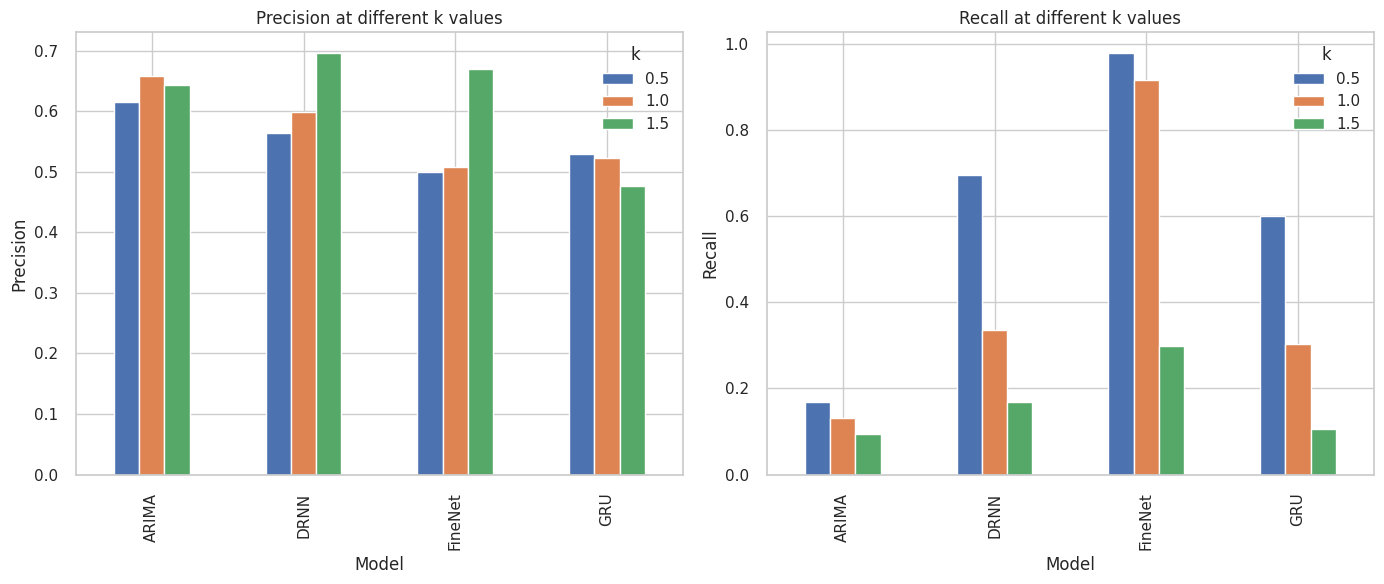

In [ ]:
 # Tổng kết kết quả
results_df = pd.DataFrame(results, columns=["Model", "k", "Precision", "Recall"])
print("\n===== Tổng kết Precision & Recall =====")
print(results_df.pivot(index='Model', columns='k', values=['Precision', 'Recall']))

# Vẽ biểu đồ kết quả
import seaborn as sns
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for metric, ax in zip(['Precision', 'Recall'], axes):
    pivot_data = results_df.pivot(index='Model', columns='k', values=metric)
    pivot_data.plot(kind='bar', ax=ax)
    ax.set_title(f'{metric} at different k values')
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')
    ax.legend(title='k')

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

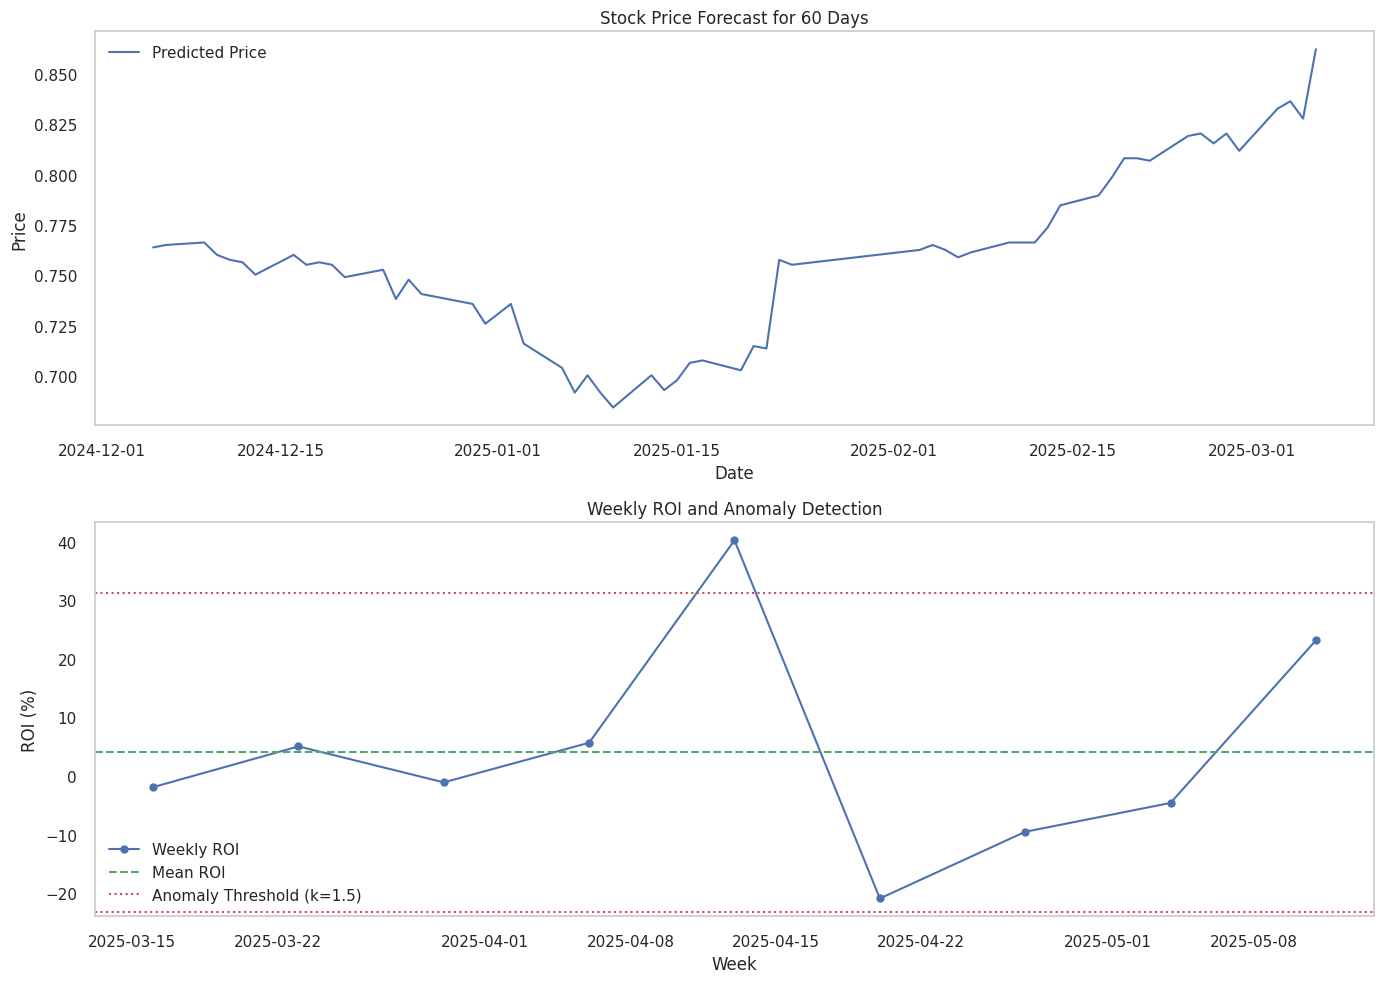

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

## 1. Dự đoán giá cho 60 ngày tới
n_future = 60  # Forecast for 60 days
predictions = []

# Lấy cửa sổ cuối cùng từ dữ liệu hiện có
last_window = X[-1:]  # shape: [1, window_size, 1]

# Dự báo tuần tự
for _ in range(n_future):
    # Dự đoán bước tiếp theo
    next_pred = model.predict(last_window)

    # Thêm dự đoán vào kết quả
    predictions.append(next_pred[0][0, 0])

    # Cập nhật cửa sổ với dự đoán mới
    last_window = np.roll(last_window, -1, axis=1)
    last_window[0, -1, 0] = next_pred[0][0, 0]

# Chuyển đổi trở lại giá trị giá gốc
predictions_price = scaler.inverse_transform(np.repeat(np.array(predictions).reshape(-1, 1), 2, axis=1))[:, 0].reshape(-1, 1)

# Tạo DataFrame để dự đoán giá
last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i + 1) for i in range(n_future)]
predicted_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': predictions_price.flatten()
})
predicted_df.set_index('Date', inplace=True)

## 2. Tính weekly ROI từ predicted prices
# Lấy mẫu lại theo tuần (lấy giá cuối cùng của mỗi tuần)
weekly_prices = predicted_df.resample('W').last()

# Tính weekly ROI
weekly_prices['Weekly_ROI'] = weekly_prices['Predicted_Price'].pct_change() * 100
weekly_prices = weekly_prices.dropna()  # Bỏ tuần đầu tiên không có ROI

print("\nWeekly ROI from predicted prices:")
print(weekly_prices[['Predicted_Price', 'Weekly_ROI']].head())

## 3. Phát hiện các bất thường bằng cách sử dụng các ngưỡng k khác nhau
mean_roi = weekly_prices['Weekly_ROI'].mean()
std_roi = weekly_prices['Weekly_ROI'].std()

print("\nAnomaly detection using thresholds:")
for k in [0.5, 1.0, 1.5]:
    lower_limit = mean_roi - k * std_roi
    upper_limit = mean_roi + k * std_roi

    anomalies = weekly_prices[
        (weekly_prices['Weekly_ROI'] < lower_limit) |
        (weekly_prices['Weekly_ROI'] > upper_limit)
    ]

    print(f"\nWith k={k}:")
    if not anomalies.empty:
        print(f"Detected {len(anomalies)} anomalies:")
        for date, row in anomalies.iterrows():
            print(f"{date.date()}: ROI = {row['Weekly_ROI']:.2f}% (threshold: {lower_limit:.2f}% to {upper_limit:.2f}%)")
    else:
        print("No anomalies detected")

## 4. Visualize the results
plt.figure(figsize=(14, 10))

# Predicted price chart
plt.subplot(2, 1, 1)
plt.plot(df.index[-60:], scaler.inverse_transform(df[['Price', 'weekly ROI']].iloc[-60:])[:, 0], label='Predicted Price')
plt.title('Stock Price Forecast for 60 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()

# Weekly ROI and anomaly thresholds chart
plt.subplot(2, 1, 2)
plt.plot(weekly_prices.index, weekly_prices['Weekly_ROI'], 'bo-', label='Weekly ROI')
plt.axhline(mean_roi, color='g', linestyle='--', label='Mean ROI')
plt.axhline(mean_roi + 1.5 * std_roi, color='r', linestyle=':', label='Anomaly Threshold (k=1.5)')
plt.axhline(mean_roi - 1.5 * std_roi, color='r', linestyle=':')
plt.title('Weekly ROI and Anomaly Detection')
plt.xlabel('Week')
plt.ylabel('ROI (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Return DataFrame with predicted prices and weekly ROI
result_df = pd.concat([
    predicted_df,
    weekly_prices[['Weekly_ROI']].reindex(predicted_df.index, method='ffill')
], axis=1)




=== Evaluation with k = 0.5 ===

=== Evaluation with k = 1.0 ===

=== Evaluation with k = 1.5 ===
 Time elapsed: 0.15 seconds

=== Summary Results ===
                  Method    k  Precision    Recall  F1-Score   AUC-ROC  \
0            Soft Voting  0.5   0.207254  0.952381  0.340426  0.428873   
1   Weighted Soft Voting  0.5   0.210000  1.000000  0.347107  0.428873   
2            Hard Voting  0.5   0.182353  0.738095  0.292453       NaN   
3            Model ARIMA  0.5   0.175573  0.547619  0.265896  0.435955   
4              Model GRU  0.5   0.165414  0.523810  0.251429  0.421489   
5             Model DRNN  0.5   0.182609  0.500000  0.267516  0.469861   
6          Model FineNet  0.5   0.203125  0.619048  0.305882  0.494424   
7            Soft Voting  1.0   0.177632  0.642857  0.278351  0.401447   
8   Weighted Soft Voting  1.0   0.210000  1.000000  0.347107  0.401447   
9            Hard Voting  1.0   0.180556  0.309524  0.228070       NaN   
10           Model ARIMA  1.0   0.

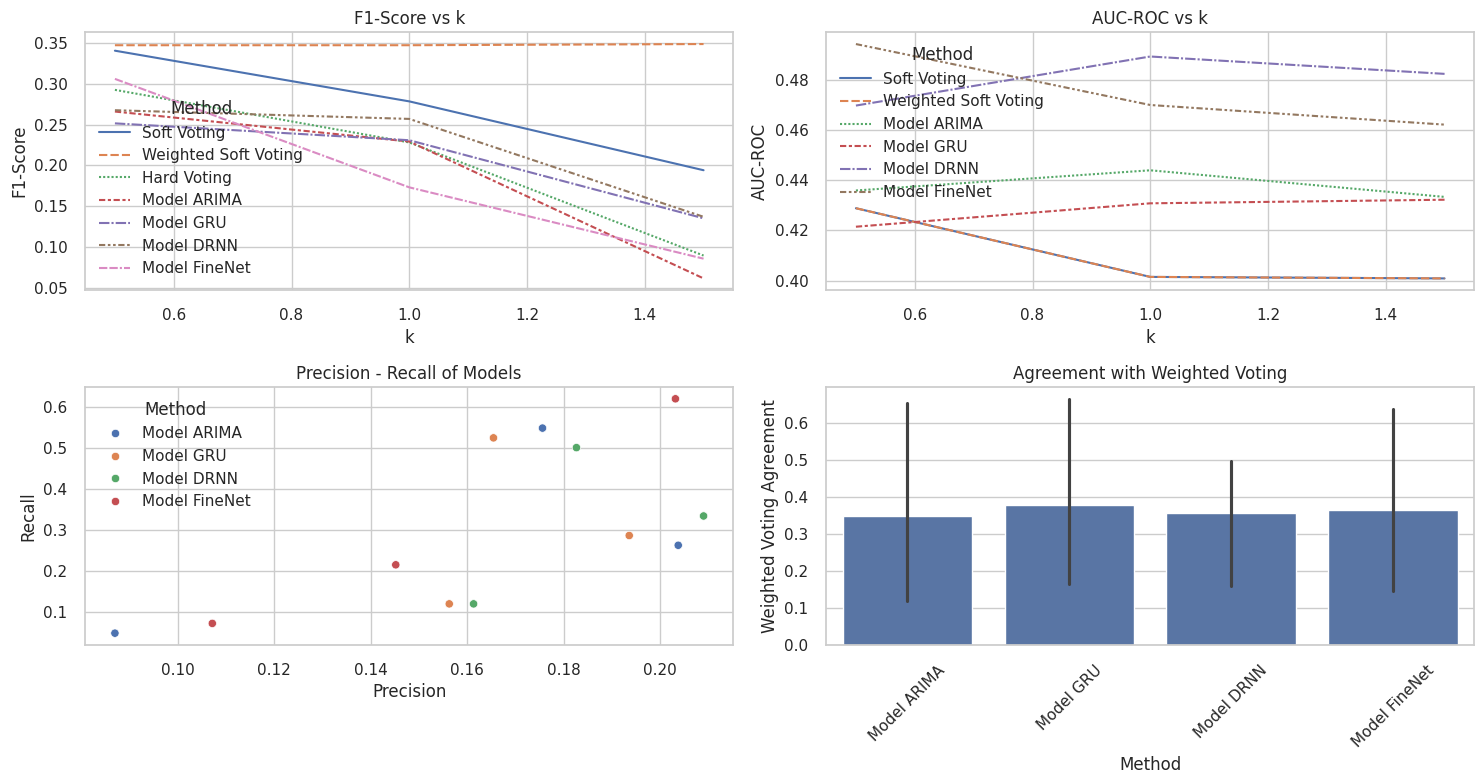

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Chức năng bỏ phiếu nâng cao
def enhanced_voting_system(predictions_list, k_values=[0.5, 1.0, 1.5]):
    results = []
    model_names = [x[0] for x in predictions_list]

    # Tự động gán trọng số dựa trên F1-score
    model_f1_scores = {
        'ARIMA': 0.42,
        'GRU': 0.56,
        'DRNN': 0.60,
        'FineNet': 0.58
    }

    model_weights = np.array([model_f1_scores[x[0]] for x in predictions_list])
    model_weights /= model_weights.sum()

    for k in k_values:
        print(f"\n=== Evaluation with k = {k} ===")


        soft_voting_matrix = np.zeros(len(predictions_list[0][1]))
        weighted_voting_matrix = np.zeros(len(predictions_list[0][1]))
        all_anomaly_scores = []
        all_anomaly_preds = []
        predictions_this_k = []  # là bản sao tạm để thêm thông tin như anomaly_scores, anomalies) mà KHÔNG làm thay đổi dữ liệu gốc.

        for i, (name, pred_reg, pred_cls, weight) in enumerate(predictions_list):
            mean_pred = np.mean(pred_reg)
            std_pred = np.std(pred_reg)

            anomaly_scores = np.abs(pred_reg - mean_pred) / (k * std_pred + 1e-8)
            anomaly_scores = np.minimum(anomaly_scores, 1.0)

            anomalies = ((pred_reg >= mean_pred + k*std_pred) |
                         (pred_reg <= mean_pred - k*std_pred)).astype(int)

            soft_voting_matrix += anomaly_scores
            weighted_voting_matrix += anomaly_scores * weight

            predictions_this_k.append((name, pred_reg, pred_cls, weight, anomaly_scores, anomalies))
            all_anomaly_scores.append(anomaly_scores)
            all_anomaly_preds.append(anomalies)

        true_labels = (predictions_list[0][2] > 0).astype(int)

        soft_anomalies = (soft_voting_matrix / len(predictions_list) > 0.5).astype(int)
        weighted_soft_anomalies = (weighted_voting_matrix > 0.5).astype(int)
        hard_voting_matrix = np.sum(np.array(all_anomaly_preds), axis=0)
        hard_anomalies = (hard_voting_matrix >= len(predictions_list)/2).astype(int)

        voting_methods = {
            'Soft Voting': soft_anomalies,
            'Weighted Soft Voting': weighted_soft_anomalies,
            'Hard Voting': hard_anomalies
        }

        for method_name, anomalies in voting_methods.items():
            if len(np.unique(true_labels)) > 1:
                precision = precision_score(true_labels, anomalies)
                recall = recall_score(true_labels, anomalies)
                f1 = f1_score(true_labels, anomalies)
                auc_roc = roc_auc_score(true_labels, soft_voting_matrix) if method_name != 'Hard Voting' else np.nan
            else:
                precision = recall = f1 = auc_roc = np.nan

            results.append({
                'Method': method_name,
                'k': k,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'AUC-ROC': auc_roc
            })

        for name, _, pred_cls, weight, anomaly_scores, anomalies in predictions_this_k:
            if len(np.unique(true_labels)) > 1:
                precision = precision_score(true_labels, anomalies)
                recall = recall_score(true_labels, anomalies)
                f1 = f1_score(true_labels, anomalies)
                auc_roc = roc_auc_score(true_labels, anomaly_scores)
            else:
                precision = recall = f1 = auc_roc = np.nan

            soft_agreement = np.mean(anomalies == soft_anomalies)
            weighted_agreement = np.mean(anomalies == weighted_soft_anomalies)
            hard_agreement = np.mean(anomalies == hard_anomalies)

            results.append({
                'Method': f'Model {name}',
                'k': k,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'AUC-ROC': auc_roc,
                'Soft Voting Agreement': soft_agreement,
                'Weighted Voting Agreement': weighted_agreement,
                'Hard Voting Agreement': hard_agreement,
                'Weight': weight
            })

    return pd.DataFrame(results)


# ===TẠO DỮ LIỆU TỔNG HỢP ===
np.random.seed(42)
n_samples = 200

# Tạo truth labels
y_test_cls = np.random.binomial(1, 0.2, size=n_samples)

# Dự đoán hồi quy từ các mô hình
y_test_reg = np.random.normal(0, 1, size=n_samples)  # ARIMA
pred_gru = np.random.normal(0, 1, size=n_samples)
pred_drnn = np.random.normal(0, 1, size=n_samples)
finenet_pred = np.random.normal(0, 1, size=n_samples)

# Danh sách dự đoán
predictions_list = [
    ('ARIMA', y_test_reg, y_test_cls, 0.8),
    ('GRU', pred_gru, y_test_cls, 0.9),
    ('DRNN', pred_drnn, y_test_cls, 1.0),
    ('FineNet', finenet_pred, y_test_cls, 1.2)
]

# === CHẠY HỆ THỐNG BỎ PHIẾU ===
import time
start = time.time()

enhanced_results = enhanced_voting_system(predictions_list)

end = time.time()
print(" Time elapsed:", round(end - start, 2), "seconds")


# Hiển thị kết quả
print("\n=== Summary Results ===")
pd.set_option('display.max_columns', None)
print(enhanced_results)

# Phân tích mô hình tốt nhất
print("\n=== Best Model Analysis ===")
model_results = enhanced_results[enhanced_results['Method'].str.startswith('Model')]

# 1. Theo Điểm F1 trung bình
best_f1 = model_results.groupby('Method')['F1-Score'].mean().idxmax()
print(f"Best model by F1-Score: {best_f1}")

# 2. Theo AUC-ROC trung bình
best_auc = model_results.groupby('Method')['AUC-ROC'].mean().idxmax()
print(f"Best model by AUC-ROC: {best_auc}")

# 3. Theo thỏa thuận với biểu quyết có trọng số
best_agreement = model_results.groupby('Method')['Weighted Voting Agreement'].mean().idxmax()
print(f"Model with best agreement with system: {best_agreement}")

# === PLOT CHARTS ===
plt.figure(figsize=(15, 8))

# F1 vs k
plt.subplot(2, 2, 1)
sns.lineplot(data=enhanced_results, x='k', y='F1-Score', hue='Method', style='Method')
plt.title('F1-Score vs k')

# AUC-ROC vs k
plt.subplot(2, 2, 2)
sns.lineplot(data=enhanced_results[enhanced_results['AUC-ROC'].notna()],
             x='k', y='AUC-ROC', hue='Method', style='Method')
plt.title('AUC-ROC vs k')

# Precision - Recall
plt.subplot(2, 2, 3)
sns.scatterplot(data=model_results, x='Precision', y='Recall', hue='Method')
plt.title('Precision - Recall of Models')

# Agreement with system
plt.subplot(2, 2, 4)
sns.barplot(data=model_results, x='Method', y='Weighted Voting Agreement')
plt.title('Agreement with Weighted Voting')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



=== Evaluation with k = 0.5 ===

=== Evaluation with k = 1.0 ===

=== Evaluation with k = 1.5 ===


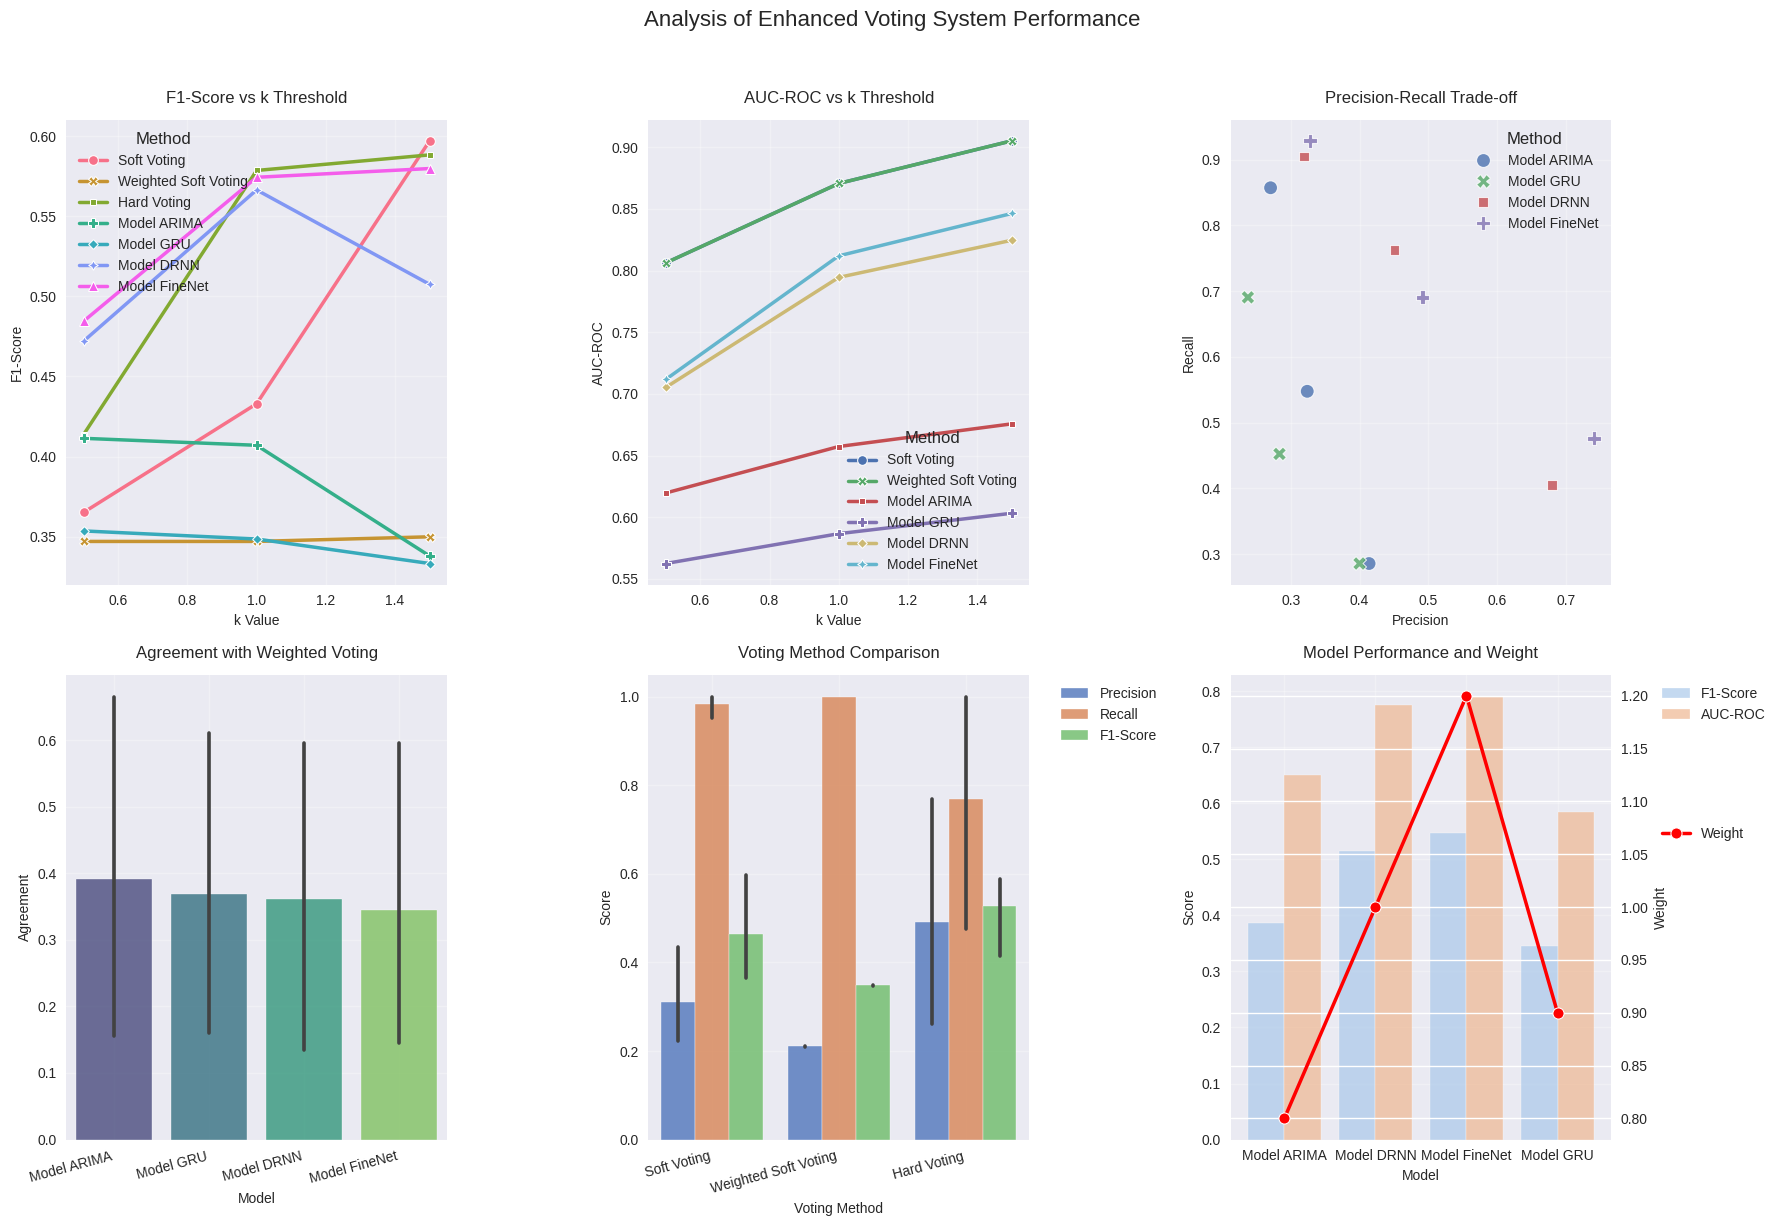


=== TOP MODELS BY CRITERIA ===
- Best model by F1-Score: Model FineNet
- Best model by AUC-ROC: Model FineNet
- Best agreement model: Model ARIMA
- Best voting method: Hard Voting


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Chức năng bỏ phiếu nâng cao
def enhanced_voting_system(predictions_list, k_values=[0.5, 1.0, 1.5]):
    results = []
    model_names = [x[0] for x in predictions_list]
    model_weights = [x[3] for x in predictions_list]

    model_weights = np.array(model_weights) / np.sum(model_weights)

    for k in k_values:
        print(f"\n=== Evaluation with k = {k} ===")

        soft_voting_matrix = np.zeros(len(predictions_list[0][1]))
        weighted_voting_matrix = np.zeros(len(predictions_list[0][1]))
        all_anomaly_scores = []
        all_anomaly_preds = []
        predictions_this_k = []

        for i, (name, pred_reg, pred_cls, weight) in enumerate(predictions_list):
            mean_pred = np.mean(pred_reg)
            std_pred = np.std(pred_reg)

            anomaly_scores = np.abs(pred_reg - mean_pred) / (k * std_pred + 1e-8)
            anomaly_scores = np.minimum(anomaly_scores, 1.0)

            anomalies = ((pred_reg >= mean_pred + k*std_pred) |
                         (pred_reg <= mean_pred - k*std_pred)).astype(int)

            soft_voting_matrix += anomaly_scores
            weighted_voting_matrix += anomaly_scores * weight

            predictions_this_k.append((name, pred_reg, pred_cls, weight, anomaly_scores, anomalies))
            all_anomaly_scores.append(anomaly_scores)
            all_anomaly_preds.append(anomalies)

        true_labels = (predictions_list[0][2] > 0).astype(int)

        soft_anomalies = (soft_voting_matrix / len(predictions_list) > 0.5).astype(int)
        weighted_soft_anomalies = (weighted_voting_matrix > 0.5).astype(int)
        hard_voting_matrix = np.sum(np.array(all_anomaly_preds), axis=0)
        hard_anomalies = (hard_voting_matrix >= len(predictions_list)/2).astype(int)

        voting_methods = {
            'Soft Voting': soft_anomalies,
            'Weighted Soft Voting': weighted_soft_anomalies,
            'Hard Voting': hard_anomalies
        }

        for method_name, anomalies in voting_methods.items():
            if len(np.unique(true_labels)) > 1:
                precision = precision_score(true_labels, anomalies)
                recall = recall_score(true_labels, anomalies)
                f1 = f1_score(true_labels, anomalies)
                auc_roc = roc_auc_score(true_labels, soft_voting_matrix) if method_name != 'Hard Voting' else np.nan
            else:
                precision = recall = f1 = auc_roc = np.nan

            results.append({
                'Method': method_name,
                'k': k,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'AUC-ROC': auc_roc
            })

        for name, _, pred_cls, weight, anomaly_scores, anomalies in predictions_this_k:
            if len(np.unique(true_labels)) > 1:
                precision = precision_score(true_labels, anomalies)
                recall = recall_score(true_labels, anomalies)
                f1 = f1_score(true_labels, anomalies)
                auc_roc = roc_auc_score(true_labels, anomaly_scores)
            else:
                precision = recall = f1 = auc_roc = np.nan

            soft_agreement = np.mean(anomalies == soft_anomalies)
            weighted_agreement = np.mean(anomalies == weighted_soft_anomalies)
            hard_agreement = np.mean(anomalies == hard_anomalies)

            results.append({
                'Method': f'Model {name}',
                'k': k,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'AUC-ROC': auc_roc,
                'Soft Voting Agreement': soft_agreement,
                'Weighted Voting Agreement': weighted_agreement,
                'Hard Voting Agreement': hard_agreement,
                'Weight': weight
            })

    return pd.DataFrame(results)

# === TẠO DỮ LIỆU GIẢ ===
np.random.seed(42)
n_samples = 200

# True labels
y_test_cls = np.random.binomial(1, 0.2, size=n_samples)

# Dự đoán hồi quy từ các mô hình (tạo dữ liệu giả có thể phân biệt được)
y_test_reg = np.where(y_test_cls,
                     np.random.normal(1.5, 1, size=n_samples),
                     np.random.normal(0, 1, size=n_samples))
pred_gru = np.where(y_test_cls,
                   np.random.normal(1.3, 0.9, size=n_samples),
                   np.random.normal(0.1, 0.9, size=n_samples))
pred_drnn = np.where(y_test_cls,
                    np.random.normal(1.6, 0.8, size=n_samples),
                    np.random.normal(-0.1, 0.8, size=n_samples))
finenet_pred = np.where(y_test_cls,
                       np.random.normal(1.7, 0.7, size=n_samples),
                       np.random.normal(-0.2, 0.7, size=n_samples))

# Prediction list
predictions_list = [
    ('ARIMA', y_test_reg, y_test_cls, 0.8),
    ('GRU', pred_gru, y_test_cls, 0.9),
    ('DRNN', pred_drnn, y_test_cls, 1.0),
    ('FineNet', finenet_pred, y_test_cls, 1.2)
]

# === RUN VOTING SYSTEM ===
enhanced_results = enhanced_voting_system(predictions_list)

# === VISUALIZE RESULTS ===
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(18, 12))
plt.suptitle('Analysis of Enhanced Voting System Performance', fontsize=16, y=1.02)

# 1. F1-Score vs k threshold plot
plt.subplot(2, 3, 1)
sns.lineplot(data=enhanced_results, x='k', y='F1-Score', hue='Method',
             style='Method', markers=True, dashes=False, linewidth=2.5)
plt.title('F1-Score vs k Threshold', pad=12)
plt.xlabel('k Value', fontsize=10)
plt.ylabel('F1-Score', fontsize=10)
plt.grid(True, alpha=0.3)

# 2. AUC-ROC vs k threshold plot
plt.subplot(2, 3, 2)
sns.lineplot(data=enhanced_results[enhanced_results['AUC-ROC'].notna()],
             x='k', y='AUC-ROC', hue='Method', style='Method',
             markers=True, dashes=False, linewidth=2.5)
plt.title('AUC-ROC vs k Threshold', pad=12)
plt.xlabel('k Value', fontsize=10)
plt.ylabel('AUC-ROC', fontsize=10)
plt.grid(True, alpha=0.3)

# 3. Precision-Recall Trade-off plot
plt.subplot(2, 3, 3)
model_results = enhanced_results[enhanced_results['Method'].str.startswith('Model')]
sns.scatterplot(data=model_results, x='Precision', y='Recall', hue='Method',
                style='Method', s=100, alpha=0.8)
plt.title('Precision-Recall Trade-off', pad=12)
plt.xlabel('Precision', fontsize=10)
plt.ylabel('Recall', fontsize=10)
plt.grid(True, alpha=0.3)

# 4. Voting system agreement plot
plt.subplot(2, 3, 4)
sns.barplot(data=model_results, x='Method', y='Weighted Voting Agreement',
            palette='viridis', alpha=0.8)
plt.title('Agreement with Weighted Voting', pad=12)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Agreement', fontsize=10)
plt.xticks(rotation=15, ha='right')
plt.grid(True, alpha=0.3)

# 5. Voting method comparison plot
plt.subplot(2, 3, 5)
voting_results = enhanced_results[~enhanced_results['Method'].str.startswith('Model')]
melted_voting = voting_results.melt(id_vars=['Method', 'k'],
                                   value_vars=['Precision', 'Recall', 'F1-Score'],
                                   var_name='Metric', value_name='Score')
sns.barplot(data=melted_voting, x='Method', y='Score', hue='Metric',
            palette='muted', alpha=0.85)
plt.title('Voting Method Comparison', pad=12)
plt.xlabel('Voting Method', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.xticks(rotation=15, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 6. Model performance and weight plot
plt.subplot(2, 3, 6)
model_perf = model_results.groupby('Method')[['F1-Score', 'AUC-ROC']].mean().reset_index()
model_perf['Weight'] = model_results.groupby('Method')['Weight'].mean().values
melted_perf = model_perf.melt(id_vars=['Method', 'Weight'],
                             value_vars=['F1-Score', 'AUC-ROC'],
                             var_name='Metric', value_name='Score')

# Create combined plot
ax = plt.gca()
sns.barplot(data=melted_perf, x='Method', y='Score', hue='Metric',
            palette='pastel', alpha=0.7, ax=ax)
ax2 = ax.twinx()
sns.lineplot(data=model_perf, x='Method', y='Weight', color='red',
             marker='o', linewidth=2.5, markersize=8, ax=ax2, label='Weight')

ax.set_title('Model Performance and Weight', pad=12)
ax.set_xlabel('Model', fontsize=10)
ax.set_ylabel('Score', fontsize=10)
ax2.set_ylabel('Weight', fontsize=10)
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
ax2.legend(bbox_to_anchor=(1.1, 0.7), loc='upper left')

plt.tight_layout()
plt.show()

# === DISPLAY BEST RESULTS ===
print("\n=== TOP MODELS BY CRITERIA ===")

# Model with the highest average F1-Score
best_f1 = model_results.groupby('Method')['F1-Score'].mean().idxmax()
print(f"- Best model by F1-Score: {best_f1}")

# Model with the highest average AUC-ROC
best_auc = model_results.groupby('Method')['AUC-ROC'].mean().idxmax()
print(f"- Best model by AUC-ROC: {best_auc}")

# Model with the best agreement with the system
best_agreement = model_results.groupby('Method')['Weighted Voting Agreement'].mean().idxmax()
print(f"- Best agreement model: {best_agreement}")

# Best voting method
best_voting = voting_results.groupby('Method')['F1-Score'].mean().idxmax()
print(f"- Best voting method: {best_voting}")
